### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [141]:
import warnings
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [91]:
# импортируем данные для обучения модели

data = pd.read_csv('train.csv', index_col=0, encoding='utf-8')

#### Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 

In [93]:
# выведем на экран первые 5 записей и убедимся в успешном импорте данных

data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [94]:
# выведем информацию о данных и проверим наличие пропусков

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [21]:
# Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). 
# По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).
# Сперва избавимся от категориальных признаков.

In [95]:
obj_features = data.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [96]:
for column in obj_features:
    print('{}\n'.format(data[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



In [97]:
# Так как признаки принимают всего два значения, заменим их на бинарные признаки.

for column in obj_features:
    unique_true = data[column].unique()[1]
    data[column]  = data[column] == unique_true
for column in obj_features:
    print('{}\n'.format(data[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



In [98]:
# Признак Healthcare_1 содержит очень много пропущенных значений. 
# Принятое решение: не учитывать этот признак в процессе анализа.

data.drop(['Healthcare_1'], axis=1, inplace=True)

In [99]:
# Признак LifeSquare также содержит пропущенные значения. 
# Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

print(data['LifeSquare'].describe())
print(data['Square'].describe())

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64
count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64


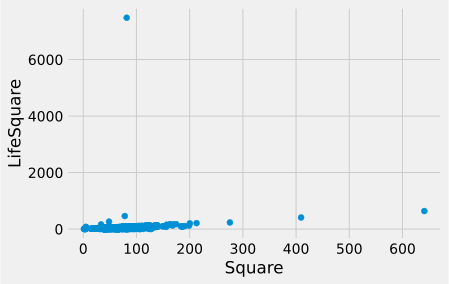

In [100]:
# строим график для понимания взаимозависимости признаков lifesquare и Square

plt.scatter(data['Square'], data['LifeSquare'])
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.show()

In [101]:
#наблюдаем выбросы на графике, избавимся от них

IQ=data['Square'].describe()['75%']-data['Square'].describe()['25%']
low_border=data['Square'].describe()['25%']-IQ*1.5
high_border=data['Square'].describe()['75%']+IQ*1.5
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format('Square', IQ, low_border, high_border))
  
size_before = data['Square'].size
data.drop(data[(data['Square']<low_border)|(data['Square']>high_border)].index, axis=0, inplace=True)    
size_after = data['Square'].size
    
lost_percentage = (size_before - size_after) * 100 / size_before 
print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [102]:
IQ=data['LifeSquare'].describe()['75%']-data['LifeSquare'].describe()['25%']
low_border=data['LifeSquare'].describe()['25%']-IQ*1.5
high_border=data['LifeSquare'].describe()['75%']+IQ*1.5
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format('LifeSquare', IQ, low_border, high_border))
  
size_before = data['LifeSquare'].size
data.drop(data[(data['LifeSquare']<low_border)|(data['LifeSquare']>high_border)].index, axis=0, inplace=True)    
size_after = data['LifeSquare'].size
    
lost_percentage = (size_before - size_after) * 100 / size_before 
print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

For column LifeSquare
	IQ:	21.756925644753355
	LOW:	-9.940131635100524
	HIGH:	77.08757094391291

Lost 1.91% of data.


In [ ]:
# Принятое решение: заполнить пропущенные значения в категории LifeSquare
# Найдём долю жилой площади от общей по средним значениям в выборке

In [103]:
square_mean_values = data[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631749

In [104]:
# заполним пропущенные значения LifeSquare с учётом найденного коэффициента

data.loc[data['LifeSquare'].isnull(), 'LifeSquare'] = data['Square'] * square_coeff

In [105]:
# данные после преобразований

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     9572 non-null   int64  
 1   Rooms          9572 non-null   float64
 2   Square         9572 non-null   float64
 3   LifeSquare     9572 non-null   float64
 4   KitchenSquare  9572 non-null   float64
 5   Floor          9572 non-null   int64  
 6   HouseFloor     9572 non-null   float64
 7   HouseYear      9572 non-null   int64  
 8   Ecology_1      9572 non-null   float64
 9   Ecology_2      9572 non-null   bool   
 10  Ecology_3      9572 non-null   bool   
 11  Social_1       9572 non-null   int64  
 12  Social_2       9572 non-null   int64  
 13  Social_3       9572 non-null   int64  
 14  Helthcare_2    9572 non-null   int64  
 15  Shops_1        9572 non-null   int64  
 16  Shops_2        9572 non-null   bool   
 17  Price          9572 non-null   float64
dtypes: b

In [106]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9.572000e+03,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000
mean,50.579816,1.845905,54.118859,34.519826,6.243105,8.471061,12.586293,4.079251e+03,0.119942,24.914333,5390.685959,8.029461,1.327518,4.237986,209182.371820
std,43.768356,0.809624,15.594497,13.030713,29.065509,5.168552,6.628252,2.049338e+05,0.119592,17.488685,3994.347092,23.702448,1.485634,4.792616,87271.970772
min,0.000000,0.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,19.000000,1.000000,41.537091,24.065821,1.000000,4.000000,9.000000,1.973000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,151904.418474
50%,36.000000,2.000000,51.217517,32.871722,6.000000,7.000000,12.000000,1.977000e+03,0.075779,25.000000,5285.000000,2.000000,1.000000,3.000000,189610.138453
75%,77.000000,2.000000,64.293638,43.319537,9.000000,12.000000,17.000000,1.999000e+03,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,244221.524382
max,209.000000,19.000000,102.032801,77.052978,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [52]:
# Наблюдаем выбросы для признаков KitchenSquare и HouseYear (по max, логически неверно). 
# Обработаем их, заменив выбросы в выборке на среднее значение по признаку.

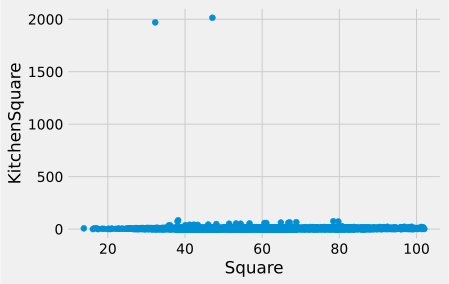

In [107]:
plt.scatter(data['Square'], data['KitchenSquare'])
plt.xlabel('Square')
plt.ylabel('KitchenSquare')
plt.show()

In [108]:
IQ=data['KitchenSquare'].describe()['75%']-data['KitchenSquare'].describe()['25%']
low_border=data['KitchenSquare'].describe()['25%']-IQ*1.5
high_border=data['KitchenSquare'].describe()['75%']+IQ*1.5
mean = data['KitchenSquare'].mean()
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format('KitchenSquare', IQ, low_border, high_border, mean))

index_to_replace = data[(data['KitchenSquare']<low_border)|(data['KitchenSquare']>high_border)].index

data.loc[index_to_replace, column] = mean
print('In {} row {} was replaced to {}.'.format(index_to_replace.size, 'KitchenSquare', mean))

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


In [109]:
# Признак HouseYear так же содержит выпадающие значения. Обработаем их.

mean_year_1 = np.round(data.loc[data['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year_1

1984.0

In [110]:
data.loc[data['HouseYear'] > 2020, 'HouseYear'] = mean_year_1

In [111]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000
mean,50.579816,1.845905,54.118859,34.519826,6.243105,8.471061,12.586293,1984.285311,0.119942,24.914333,5390.685959,8.029461,1.327518,4.237986,209182.371820
std,43.768356,0.809624,15.594497,13.030713,29.065509,5.168552,6.628252,18.135698,0.119592,17.488685,3994.347092,23.702448,1.485634,4.792616,87271.970772
min,0.000000,0.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,19.000000,1.000000,41.537091,24.065821,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,151904.418474
50%,36.000000,2.000000,51.217517,32.871722,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,5285.000000,2.000000,1.000000,3.000000,189610.138453
75%,77.000000,2.000000,64.293638,43.319537,9.000000,12.000000,17.000000,1999.000000,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,244221.524382
max,209.000000,19.000000,102.032801,77.052978,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


Выбросов нет. В процессе подготовки данных:

    1) Были заменены категориальные признаки на бинарные. 
    2) Исключен из анализа признак Healthcare_1. 
    3) Исключены выбросы из выборки по признакам Square и LifeSquare. 
    4) Заполнены пропущенные значения по признаку LifeSquare. 
    5) Заменены выбросы по признаку KitchenSquare и HouseYear на средние значения. 
    
Сделаем то же самое для тестового датафрейма.

In [112]:
test = pd.read_csv('test.csv', index_col=0, encoding='utf-8')

In [113]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [114]:
for column in obj_features:
    unique_true = test[column].unique()[1]
    test[column]  = test[column] == unique_true

In [115]:
test.drop(['Healthcare_1'], axis=1, inplace=True)

In [116]:
IQ=test['Square'].describe()['75%']-test['Square'].describe()['25%']
low_border=test['Square'].describe()['25%']-IQ*1.5
high_border=test['Square'].describe()['75%']+IQ*1.5
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format('Square', IQ, low_border, high_border))
  
size_before = test['Square'].size
test.drop(test[(test['Square']<low_border)|(test['Square']>high_border)].index, axis=0, inplace=True)    
size_after = test['Square'].size
    
lost_percentage = (size_before - size_after) * 100 / size_before 
print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048

Lost 2.20% of data.


In [117]:
IQ=test['LifeSquare'].describe()['75%']-test['LifeSquare'].describe()['25%']
low_border=test['LifeSquare'].describe()['25%']-IQ*1.5
high_border=test['LifeSquare'].describe()['75%']+IQ*1.5
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format('LifeSquare', IQ, low_border, high_border))
  
size_before = test['LifeSquare'].size
test.drop(test[(test['LifeSquare']<low_border)|(test['LifeSquare']>high_border)].index, axis=0, inplace=True)    
size_after = test['LifeSquare'].size
    
lost_percentage = (size_before - size_after) * 100 / size_before 
print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

For column LifeSquare
	IQ:	21.593453392655356
	LOW:	-9.340938098054458
	HIGH:	77.03287547256696

Lost 1.98% of data.


In [118]:
square_mean_values = test[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6380200071838058

In [119]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['Square'] * square_coeff

In [120]:
IQ=test['KitchenSquare'].describe()['75%']-test['KitchenSquare'].describe()['25%']
low_border=test['KitchenSquare'].describe()['25%']-IQ*1.5
high_border=test['KitchenSquare'].describe()['75%']+IQ*1.5
mean = test['KitchenSquare'].mean()
    
print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format('KitchenSquare', IQ, low_border, high_border, mean))

index_to_replace = test[(test['KitchenSquare']<low_border)|(test['KitchenSquare']>high_border)].index

test.loc[index_to_replace, column] = mean
print('In {} row {} was replaced to {}.'.format(index_to_replace.size, 'KitchenSquare', mean))

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.973503025245149
In 13 row KitchenSquare was replaced to 5.973503025245149.


In [121]:
mean_year_2 = np.round(test.loc[test['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year_2

1984.0

In [123]:
test.loc[test['HouseYear'] > 2020, 'HouseYear'] = mean_year_2

In [130]:
# Разобьем тестовый датасет на тестовый и валидационный.

features = data.columns.drop('DistrictId').drop('Price')
target = 'Price'

In [131]:
X = pd.DataFrame(data, columns=features)
y = pd.DataFrame(data, columns=[target])

In [132]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [133]:
X_test = test[features]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,
725,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,False,False,11,2748,1,0,0,False
15856,2.0,69.263183,44.191297,1.0,6,1.0,1977,0.075779,False,False,6,1437,3,0,2,False
5480,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,False,False,30,7538,87,5,5,False
15664,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,False,False,23,4583,3,3,3,False
14275,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,False,False,2,629,1,0,0,True


In [134]:
# Масштабируем данные

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

Наилучший результат на тренировочном наборе был получен на модели RandomForestRegressor с параметрами n_estimators=1000, max_depth=9, max_features=7, random_state=42. LinearRegression, Lasso и Ridge показали примерно равный результат к-та детерминации в области 0.5

In [142]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)

# Функция считает метрику r2_score и mae по переданным наборам данных и модели.

def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')
    
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8177482755099208, mae_train: 24432.483962272396
r2_test = 0.6793736868990652, mae_test: 30156.543121349187


In [148]:
# Предсказываем цены для тестового датасета и выгружаем результат в файл

price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['DistrictId'], 'Price': price }).to_csv('ASerPetrenko_predictions.csv', index=False)

### Вывод: 

Используя данные из train.csv, была построена модель для предсказания цен на недвижимость (квартиры). Предварительно датасеты (и тестовый, и тренировочный) были обработаны, а именно следующим образом:

    1) Были заменены категориальные признаки на бинарные. 
    2) Исключен из анализа признак Healthcare_1 в силу наибольшего относ. коэф-та отсутствия данных по отношению к остальным признакам. 
    3) Исключены выбросы из выборки по признакам Square и LifeSquare. 
    4) Заполнены пропущенные значения по признаку LifeSquare. 
    5) Заменены выбросы по признаку KitchenSquare и HouseYear на средние значения. 
    
По результатам сравнения коэффициентов детерминации r2_score, выбор был сделан в пользу модели RandomForestRegressor со значением r2_test = 0.679. С помощью полученной модели удалось предсказать цены для квартир из файла test.csv, загрузив их в новый файл csv.